In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

---
Example of Time Series Modelling - Building an AR Model
=====
***

####Going to use Ebola Deaths as an example

In [2]:
df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/cmrivers/ebola/master/country_timeseries.csv',\
                           index_col=0)

In [3]:
df.columns

Index([u'Day', u'Cases_Guinea', u'Cases_Liberia', u'Cases_SierraLeone',
       u'Cases_Nigeria', u'Cases_Senegal', u'Cases_UnitedStates',
       u'Cases_Spain', u'Cases_Mali', u'Deaths_Guinea', u'Deaths_Liberia',
       u'Deaths_SierraLeone', u'Deaths_Nigeria', u'Deaths_Senegal',
       u'Deaths_UnitedStates', u'Deaths_Spain', u'Deaths_Mali'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2015-01-05 to 2014-03-22
Data columns (total 17 columns):
Day                    122 non-null int64
Cases_Guinea           93 non-null float64
Cases_Liberia          83 non-null float64
Cases_SierraLeone      87 non-null float64
Cases_Nigeria          38 non-null float64
Cases_Senegal          25 non-null float64
Cases_UnitedStates     18 non-null float64
Cases_Spain            16 non-null float64
Cases_Mali             12 non-null float64
Deaths_Guinea          92 non-null float64
Deaths_Liberia         81 non-null float64
Deaths_SierraLeone     87 non-null float64
Deaths_Nigeria         38 non-null float64
Deaths_Senegal         22 non-null float64
Deaths_UnitedStates    18 non-null float64
Deaths_Spain           16 non-null float64
Deaths_Mali            12 non-null float64
dtypes: float64(16), int64(1)
memory usage: 17.2 KB


####We need to impute missing data values, in order to preserve as much of the time series as possible

###Look at "both" ends of this data

In [5]:
deathColList = ["Deaths_Guinea", "Deaths_Liberia", "Deaths_SierraLeone"]

df.sort("Day", ascending=False)[deathColList][1:2]

Deaths_Guinea  Deaths_Liberia  Deaths_SierraLeone
Date                                                         
2015-01-04           1781             NaN                2943

In [6]:
df.sort("Day", ascending=True)[deathColList][1:2]

Deaths_Guinea  Deaths_Liberia  Deaths_SierraLeone
Date                                                         
2014-03-24             59             NaN                 NaN

##### Use both a backfill AND a forward fill in order to fill all the NAs. 

In [7]:
df1 = df.bfill()
df1 = df1.ffill()

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2015-01-05 to 2014-03-22
Data columns (total 17 columns):
Day                    122 non-null int64
Cases_Guinea           122 non-null float64
Cases_Liberia          122 non-null float64
Cases_SierraLeone      122 non-null float64
Cases_Nigeria          122 non-null float64
Cases_Senegal          122 non-null float64
Cases_UnitedStates     122 non-null float64
Cases_Spain            122 non-null float64
Cases_Mali             122 non-null float64
Deaths_Guinea          122 non-null float64
Deaths_Liberia         122 non-null float64
Deaths_SierraLeone     122 non-null float64
Deaths_Nigeria         122 non-null float64
Deaths_Senegal         122 non-null float64
Deaths_UnitedStates    122 non-null float64
Deaths_Spain           122 non-null float64
Deaths_Mali            122 non-null float64
dtypes: float64(16), int64(1)
memory usage: 17.2 KB


In [9]:
df1.sort("Day", ascending=False)[deathColList][1:2]

Deaths_Guinea  Deaths_Liberia  Deaths_SierraLeone
Date                                                         
2015-01-04           1781            3496                2943

In [10]:
df1.sort("Day", ascending=True)[deathColList][1:2]

Deaths_Guinea  Deaths_Liberia  Deaths_SierraLeone
Date                                                         
2014-03-24             59               6                   5

In [11]:
deaths_df = df1[deathColList]

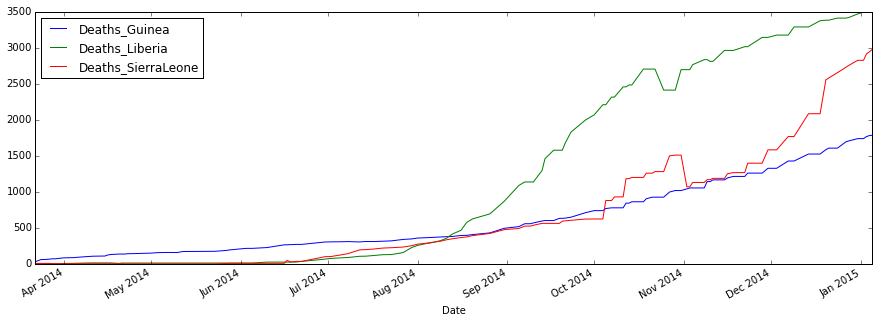

In [12]:
deaths_df.plot(figsize=(15,5))

---
#Auto-regressive Modelling
---

---
###- time series x[t-5], x[t-4], x[t-3], x[t-2], x[t-1], x[t], y
###- y is the first future point, we are trying to predict y
###- build a model to predict the current values 
###- x[t] =  theta0 + theta1 * x[t-1] + theta2 * x[t-2] + theta3 * x[t-3]
###- x[t-1] = theta0 + theta1 * x[t -2] + theta2 * [t-3] + theta3 * x[t-4]
###- etc etc...utilizing past data
###- Then use the parameters theta to predict y, using y = theta0 + theta1 * x[t] + theta2 * x[t-1] + theta3 * x[t-2]
---

####The following cell illustrates basic time series modelling
####It's a good start to get your head round what's going on, in terms of lagging columns
####The data has only a single column
####You lag this column by 1 time value to create a new column
####Your Auto-regressive model size determines how many lagged columns you create
####Then you build your model using the *rows* of all the lagged columns

In [13]:
colList = deaths_df.columns

#For example purposes just try and predict the deaths for the first country in the column list
#So the data just has a single column of data
cols = colList[0]

#For convenience set the deaths column to y
y = deaths_df[cols]
y.head(2)

Date
2015-01-05    1786
2015-01-04    1781
Name: Deaths_Guinea, dtype: float64

In [14]:
#We use the first half of the data to train on
#This is not ideal - you really want to use a fixed size moving window to train on as your time series progresses
#However, this is not a bad place to start!
print "y has {:d} many rows".format(len(y))
train_end = len(y)/2
print "training location end is {:d}".format(train_end)

print "So the first 5 rows of data that we will be predicting are:"
print "--------------------------------"
print y[train_end: train_end + 5]
print "--------------------------------\n"

y has 122 many rows
training location end is 61
So the first 5 rows of data that we will be predicting are:
--------------------------------
Date
2014-08-18    396
2014-08-16    394
2014-08-13    380
2014-08-11    377
2014-08-09    373
Name: Deaths_Guinea, dtype: float64
--------------------------------



In [15]:
#ar_size represents the size of your Auto-regressive model
#so if your model size is 4 then use x1 (at time t-4), x2 (at time t-3), x3 (at time t-2), x4 (at time t-1)
#to predict x5 (the current value)

ar_size = 4
    
#Obviously you need to lag your column by 1, up to ar_size in order to get your training data
#You get as many columns as you need because of ar_size
lagged = pd.concat([y.shift(i+1) for i in xrange(ar_size)], axis=1)
lagged.columns = ['DG_lag1', 'DG_lag2', 'DG_lag3', 'DG_lag4']

print "here are the first 10 rows of the lagged data"
print "ar_size if 4 so you have 4 columns, each lagged by 1"
print "clearly you can't use the first ar_size rows because as you lag you create NaNs"
print "--------------------------------"
print lagged[0:10], "\n\n"
print "--------------------------------\n"
print "--------------------------------"
print lagged[train_end: train_end + 10], "\n\n"
print "--------------------------------\n"

here are the first 10 rows of the lagged data
ar_size if 4 so you have 4 columns, each lagged by 1
clearly you can't use the first ar_size rows because as you lag you create NaNs
--------------------------------
            DG_lag1  DG_lag2  DG_lag3  DG_lag4
Date                                          
2015-01-05      NaN      NaN      NaN      NaN
2015-01-04     1786      NaN      NaN      NaN
2015-01-03     1781     1786      NaN      NaN
2015-01-02     1767     1781     1786      NaN
2014-12-31     1739     1767     1781     1786
2014-12-28     1739     1739     1767     1781
2014-12-27     1708     1739     1739     1767
2014-12-24     1697     1708     1739     1739
2014-12-21     1607     1697     1708     1739
2014-12-20     1607     1607     1697     1708 


--------------------------------

--------------------------------
            DG_lag1  DG_lag2  DG_lag3  DG_lag4
Date                                          
2014-08-18      406      430      494      517
2014-08-16   

In [16]:
#The training set will consist of all the lagged columns and the first half of the rows
#Here's your X and y for the model:
X = lagged.ix[ar_size:train_end]
yy = y.ix[ar_size:train_end]
print X.ix[0:5]
print yy.ix[0:5]

            DG_lag1  DG_lag2  DG_lag3  DG_lag4
Date                                          
2014-12-31     1739     1767     1781     1786
2014-12-28     1739     1739     1767     1781
2014-12-27     1708     1739     1739     1767
2014-12-24     1697     1708     1739     1739
2014-12-21     1607     1697     1708     1739
Date
2014-12-31    1739
2014-12-28    1708
2014-12-27    1697
2014-12-24    1607
2014-12-21    1607
Name: Deaths_Guinea, dtype: float64


In [17]:
#Look at the five rows of the training set and test set
#See what pd.shift is doing
print "--------------------------------"
print "Build a model using these values: \n",
for m in xrange(5):
    for k in xrange(ar_size - 1, -1, -1):
        print X.ix[m][k],
    print "to predict this value: ",
    print yy[m],
    print "and"
print "--------------------------------\n"

--------------------------------
Build a model using these values: 
1786.0 1781.0 1767.0 1739.0 to predict this value:  1739.0 and
1781.0 1767.0 1739.0 1739.0 to predict this value:  1708.0 and
1767.0 1739.0 1739.0 1708.0 to predict this value:  1697.0 and
1739.0 1739.0 1708.0 1697.0 to predict this value:  1607.0 and
1739.0 1708.0 1697.0 1607.0 to predict this value:  1607.0 and
--------------------------------



---
###Fit a single model to the first half of your data to predict the second half
---

In [18]:
y = deaths_df[cols]
train_end = len(y)/2
ar_size = 4
lagged = pd.concat([y.shift(i+1) for i in xrange(ar_size)], axis=1)
lagged.columns = [range(ar_size)]
X = lagged.ix[ar_size:train_end]
yy = y.ix[ar_size:train_end]
lagged.ix[0:10]

0     1     2     3
Date                              
2015-01-05   NaN   NaN   NaN   NaN
2015-01-04  1786   NaN   NaN   NaN
2015-01-03  1781  1786   NaN   NaN
2015-01-02  1767  1781  1786   NaN
2014-12-31  1739  1767  1781  1786
2014-12-28  1739  1739  1767  1781
2014-12-27  1708  1739  1739  1767
2014-12-24  1697  1708  1739  1739
2014-12-21  1607  1697  1708  1739
2014-12-20  1607  1607  1697  1708

In [19]:
#Now fit your model    
clf = LinearRegression()
clf.fit(X, yy)
    
predictions = []
#Now use the model to predict the second half of the data
mse = 0.0
count = 0.0
print "------------------------------------"
print "Predicted        Actual       Error"
for t in xrange(train_end, len(y)):
    y_hat = clf.predict(lagged.ix[t])
    print "{:11.2f} {:11.2f} {:11.2f}".format(y_hat[0], y.ix[t], np.abs(y_hat[0]-y.ix[t]))
    mse += (y_hat[0]-y.ix[t]) * (y_hat[0]-y.ix[t])
    count += 1
mse = np.sqrt(mse)/count
print "Mean Squared Error is {0:}".format(mse)

------------------------------------
Predicted        Actual       Error
     391.83      396.00        4.17
     382.28      394.00       11.72
     374.53      380.00        5.47
     364.55      377.00       12.45
     356.11      373.00       16.89
     354.17      367.00       12.83
     348.03      363.00       14.97
     343.33      358.00       14.67
     339.08      346.00        6.92
     329.73      339.00        9.27
     320.68      319.00        1.68
     306.85      314.00        7.15
     295.13      310.00       14.87
     292.72      310.00       17.28
     289.95      304.00       14.05
     286.46      309.00       22.54
     286.53      307.00       20.47
     288.32      305.00       16.68
     285.04      303.00       17.96
     283.68      270.00       13.68
     263.08      270.00        6.92
     248.92      267.00       18.08
     251.50      267.00       15.50
     247.35      264.00       16.65
     245.96      264.00       18.04
     244.40      226.00    

---
###Use a moving window
###This trains a new model as the window slides over the data
###The window is of fixed size
###This means the latest data gets incorporated into a new model and old data drops out the back of the window
---

In [20]:
y = deaths_df[cols]
train_end = len(y)/2
ar_size = 4
lagged = pd.concat([y.shift(i+1) for i in xrange(ar_size)], axis=1)
lagged.columns = [range(ar_size)]
clfB = LinearRegression()

predictionsB = []
#Now use the model to predict the second half of the data
mseB = 0.0
countB = 0.0
print "------------------------------------"
print "Predicted        Actual       Error"
for t in xrange(train_end, len(y)):
    XB = lagged.ix[t - train_end + ar_size: t - 1]
    yyB = y.ix[t - train_end + ar_size: t - 1]
    clf.fit(XB, yyB)
    y_hatB = clf.predict(lagged.ix[t])
    print "{:11.2f} {:11.2f} {:11.2f}".format(y_hatB[0], y.ix[t], np.abs(y_hatB[0]-y.ix[t]))
    mseB += (y_hatB[0]-y.ix[t]) * (y_hatB[0]-y.ix[t])
    countB += 1
mseB = np.sqrt(mseB)/countB
print "Mean Squared Error is {0:}".format(mseB)

------------------------------------
Predicted        Actual       Error
     396.22      396.00        0.22
     386.15      394.00        7.85
     376.97      380.00        3.03
     367.34      377.00        9.66
     358.21      373.00       14.79
     357.52      367.00        9.48
     353.70      363.00        9.30
     348.31      358.00        9.69
     345.95      346.00        0.05
     334.36      339.00        4.64
     326.52      319.00        7.52
     309.35      314.00        4.65
     300.05      310.00        9.95
     295.34      310.00       14.66
     292.12      304.00       11.88
     286.90      309.00       22.10
     291.67      307.00       15.33
     291.43      305.00       13.57
     290.39      303.00       12.61
     290.46      270.00       20.46
     265.05      270.00        4.95
     264.43      267.00        2.57
     257.19      267.00        9.81
     256.39      264.00        7.61
     254.33      264.00        9.67
     255.22      226.00    